In [153]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import e
from marchMadnessBracket.torch_bracket import *

In [368]:
def do_full_bracket_multi_level(rankings,prob):
    probs = torch.Tensor()
    power = math.log(rankings.shape[0])/math.log(2)
    assert power.is_integer(), "must be multiple of two"
    power = int(power)
    for x in range(power):
        l_power = 2**x
        prob,n_rounds = one_round(rankings,prob,2*l_power,l_power,logisitic)
        probs = torch.cat( (probs,prob) )
        #print(prob)
    return probs

In [369]:
xpower = torch.arange(1, 65,dtype=float)
xp = torch.full((1, 64), 1.)

In [370]:
xpower,xp

(tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
         29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
         43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
         57., 58., 59., 60., 61., 62., 63., 64.], dtype=torch.float64),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))

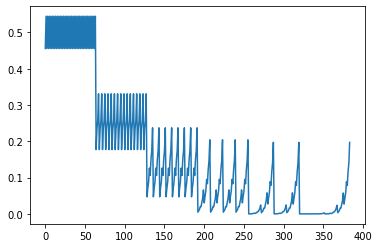

In [371]:
prob = do_full_bracket_multi_level(xpower,xp)
plt.plot(prob)

In [372]:
from marchMadnessBracket.utils import *
from marchMadnessBracket.Team import Team
from marchMadnessBracket.Bracket import Bracket
teams = [['Gonzaga', 25.9],
 ['NORF/APPST', 4.2],
 ['Oklahoma', 14.1],
 ['Missouri', 11.4],
 ['Creighton', 16.9],
 ['UCSB', 6.4],
 ['Virginia', 16.2],
 ['Ohio', 5.2],
 ['USC', 15.9],
 ['WICH/DRKE', 8.4],
 ['Kansas', 17.1],
 ['Eastern Wash.', 4.6],
 ['Oregon', 13.9],
 ['VCU', 10.7],
 ['Iowa', 20.9],
 ['Grand Canyon', 4.5],
 ['Michigan', 20.4],
 ['MSM/TXSO', 4.0],
 ['LSU', 14.6],
 ['St. Bonaventure', 12.7],
 ['Colorado', 16.0],
 ['Georgetown', 9.7],
 ['Florida St.', 16.7],
 ['N.C. Greensboro', 5.1],
 ['BYU', 13.9],
 ['MSU/UCLA', 12.6],
 ['Texas', 16.5],
 ['Abilene Christian', 6.0],
 ['Connecticut', 15.2],
 ['Maryland', 12.6],
 ['Alabama', 18.0],
 ['Iona', 0.1],
 ['Baylor', 23.1],
 ['Hartford', 2.4],
 ['North Carolina', 14.9],
 ['Wisconsin', 15.9],
 ['Villanova', 17.9],
 ['Winthrop', 5.8],
 ['Purdue', 15.2],
 ['North Texas', 7.9],
 ['Texas Tech', 16.9],
 ['Utah St.', 12.1],
 ['Arkansas', 16.2],
 ['Colgate', 8.8],
 ['Florida', 13.2],
 ['Virginia Tech', 12.3],
 ['Ohio St.', 17.5],
 ['Oral Roberts', 0.9],
 ['Illinois', 21.7],
 ['Drexel', 0.8],
 ['Loyola (IL)', 13.9],
 ['Georgia Tech', 13.1],
 ['Tennessee', 16.5],
 ['Oregon St.', 7.8],
 ['Oklahoma St.', 14.3],
 ['Liberty', 4.6],
 ['SDSU', 14.5],
 ['Syracuse', 12.3],
 ['West Virginia', 16.2],
 ['Morehead St.', 0.1],
 ['Clemson', 12.5],
 ['Rutgers', 13.0],
 ['Houston', 19.9],
 ['Cleveland St.', 2.0]]

teams = list(map(lambda x: Team(*x), teams))

In [373]:
ratings = []
names = []
for team in teams:
    ratings.append(team.rating)
    names.append(team.name)

In [374]:
ratings_tensor = torch.Tensor(ratings)

tensor(63.)

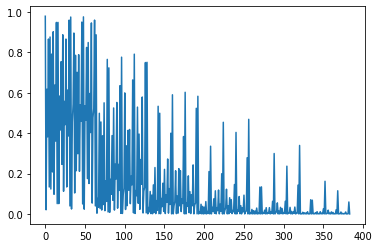

In [375]:
prob = do_full_bracket_multi_level(ratings_tensor,xp)
plt.plot(prob)
prob.sum()

In [376]:
names_prob = list(zip(names,prob))
sorted(names_prob,key=lambda x: -x[1])

[('Gonzaga', tensor(0.9795)),
 ('Illinois', tensor(0.9765)),
 ('Baylor', tensor(0.9756)),
 ('Alabama', tensor(0.9605)),
 ('Houston', tensor(0.9605)),
 ('Ohio St.', tensor(0.9507)),
 ('Iowa', tensor(0.9490)),
 ('Michigan', tensor(0.9490)),
 ('West Virginia', tensor(0.9463)),
 ('Kansas', tensor(0.9027)),
 ('Villanova', tensor(0.8963)),
 ('Florida St.', tensor(0.8877)),
 ('Virginia', tensor(0.8766)),
 ('Creighton', tensor(0.8666)),
 ('Texas', tensor(0.8666)),
 ('Oklahoma St.', tensor(0.8493)),
 ('Tennessee', tensor(0.8250)),
 ('USC', tensor(0.7919)),
 ('Arkansas', tensor(0.7890)),
 ('Purdue', tensor(0.7860)),
 ('Colorado', tensor(0.7545)),
 ('Texas Tech', tensor(0.7017)),
 ('Oregon', tensor(0.6388)),
 ('Oklahoma', tensor(0.6180)),
 ('Connecticut', tensor(0.6138)),
 ('SDSU', tensor(0.5968)),
 ('LSU', tensor(0.5839)),
 ('BYU', tensor(0.5577)),
 ('Wisconsin', tensor(0.5444)),
 ('Florida', tensor(0.5400)),
 ('Loyola (IL)', tensor(0.5356)),
 ('Rutgers', tensor(0.5223)),
 ('Clemson', tensor(0.4

In [377]:
human_picks = {'Gonzaga': [97.7184, 93.121, 85.7853, 72.3422, 59.9904, 43.5631],
 'Baylor': [96.1392, 82.5877, 70.2927, 50.7066, 29.6117, 8.6977],
 'Iowa': [95.9706, 77.2913, 48.3535, 10.8907, 5.5001, 2.4422],
 'Michigan': [95.6712, 84.333, 66.9569, 46.4992, 14.843, 9.0988],
 'Illinois': [95.5053, 87.9137, 72.8701, 57.482, 33.7767, 15.6837],
 'Ohio St.': [95.2931, 80.7313, 59.1219, 24.7422, 10.2383, 3.0282],
 'Kansas': [93.9874, 70.0629, 33.5628, 7.9222, 3.9552, 2.0714],
 'Houston': [93.5286, 76.5244, 43.6078, 14.1668, 5.8786, 1.6965],
 'Texas': [92.6278, 69.8685, 36.6484, 14.919, 2.9774, 1.1377],
 'Alabama': [92.4722, 73.4387, 42.4985, 19.3409, 4.5083, 1.8481],
 'West Virginia': [90.7206, 62.7244, 34.7381, 9.3002, 3.4422, 0.9458],
 'Florida St.': [90.2665, 59.6703, 18.6316, 7.7381, 1.4897, 0.5972],
 'Purdue': [88.6197, 43.8941, 7.8438, 2.8696, 1.0671, 0.3829],
 'Arkansas': [85.1917, 51.1321, 17.9848, 5.3602, 1.8732, 0.5729],
 'Virginia': [84.5838, 53.8875, 6.9071, 3.2329, 1.3913, 0.6729],
 'Oklahoma St.': [84.2984, 55.0067, 13.0297, 7.7763, 3.3117, 0.9377],
 'USC': [79.3014, 23.2515, 8.0756, 0.857, 0.3313, 0.1768],
 'Tennessee': [75.7456, 33.7112, 6.6588, 2.5973, 0.8784, 0.288],
 'Creighton': [74.9402, 33.7112, 2.271, 0.7962, 0.3353, 0.1445],
 'Villanova': [73.7188, 44.7711, 11.067, 5.7852, 3.0688, 0.9144],
 'Texas Tech': [72.9478, 36.7414, 12.5516, 2.4436, 0.773, 0.2647],
 'LSU': [66.9249, 9.3682, 4.1221, 1.3564, 0.3503, 0.1576],
 'Oregon': [66.9175, 16.454, 5.9151, 0.9804, 0.4307, 0.2193],
 'BYU': [66.6404, 18.4329, 7.198, 1.2066, 0.249, 0.1122],
 'Oklahoma': [60.8307, 2.9651, 1.6843, 0.4838, 0.1707, 0.0738],
 'Clemson': [58.0413, 13.1452, 3.9398, 1.1518, 0.3965, 0.1273],
 'SDSU': [55.768, 22.1122, 9.4254, 1.6738, 0.6234, 0.2577],
 'North Carolina': [52.9535, 9.0819, 5.2043, 2.7912, 1.3622, 0.6709],
 'Florida': [51.2196, 9.891, 3.6586, 0.9226, 0.4367, 0.1748],
 'Loyola (IL)': [50.4532, 4.9852, 2.1333, 0.8942, 0.3754, 0.1586],
 'Connecticut': [49.8638, 13.0389, 4.8329, 1.6689, 0.525, 0.3223],
 'Colorado': [48.52, 19.7513, 3.2814, 1.1841, 0.2961, 0.1344],
 'Georgetown': [47.6266, 16.0586, 2.9614, 1.2771, 0.4859, 0.3193],
 'Maryland': [46.0391, 8.7784, 2.6007, 0.4975, 0.1526, 0.0717],
 'Georgia Tech': [45.0438, 3.7157, 1.5379, 0.6454, 0.254, 0.1213],
 'Virginia Tech': [44.4785, 5.9503, 2.3641, 0.4094, 0.1576, 0.0717],
 'Wisconsin': [43.1931, 5.282, 2.3845, 1.044, 0.3724, 0.19],
 'Syracuse': [39.6604, 10.5793, 3.7624, 1.3271, 0.7298, 0.5244],
 'Rutgers': [37.2537, 6.2193, 1.344, 0.2938, 0.1154, 0.0606],
 'Missouri': [36.4669, 1.7444, 0.7021, 0.2938, 0.1265, 0.0738],
 'VCU': [30.3153, 3.4553, 0.8562, 0.1606, 0.0663, 0.0293],
 'St. Bonaventure': [29.003, 2.5955, 0.799, 0.3056, 0.0914, 0.0404],
 'MSU/UCLA': [27.409, 6.4797, 1.9685, 0.6679, 0.2439, 0.1768],
 'Utah St.': [22.9237, 5.3634, 0.864, 0.2047, 0.0803, 0.0374],
 'UCSB': [22.5789, 5.4811, 0.4073, 0.1704, 0.0853, 0.0404],
 'Winthrop': [22.5307, 6.8292, 0.5498, 0.237, 0.0964, 0.0333],
 'Oregon St.': [19.7746, 3.9847, 0.6768, 0.2674, 0.1446, 0.0647],
 'WICH/DRKE': [16.1177, 2.6884, 0.5227, 0.1401, 0.0632, 0.0323],
 'Ohio': [13.1846, 4.8292, 0.6594, 0.191, 0.0823, 0.0354],
 'Liberty': [11.4868, 4.1752, 0.5789, 0.1988, 0.0783, 0.0313],
 'Colgate': [11.0921, 3.843, 0.9551, 0.3379, 0.1968, 0.0354],
 'North Texas': [7.7086, 1.6659, 0.3268, 0.1332, 0.0572, 0.0364],
 'N.C. Greensboro': [6.0627, 1.5481, 0.3093, 0.1234, 0.0542, 0.0202],
 'Morehead St.': [5.1619, 1.4074, 0.3956, 0.141, 0.0723, 0.0263],
 'Iona': [4.667, 1.9474, 0.9125, 0.5543, 0.4136, 0.0404],
 'Eastern Wash.': [4.0507, 1.259, 0.3442, 0.1156, 0.0522, 0.0212],
 'Abilene Christian': [4.0443, 1.4897, 0.4897, 0.2272, 0.0763, 0.0404],
 'Cleveland St.': [2.9961, 1.0646, 0.3888, 0.143, 0.0632, 0.0303],
 'Grand Canyon': [2.6959, 1.0321, 0.4596, 0.1704, 0.0863, 0.0495],
 'Oral Roberts': [1.9211, 0.7573, 0.3384, 0.1303, 0.0532, 0.0253],
 'Drexel': [1.6134, 0.6788, 0.3801, 0.2125, 0.0984, 0.0546],
 'Hartford': [1.5476, 0.539, 0.289, 0.1694, 0.0803, 0.0424],
 'MSM/TXSO': [0.9814, 0.4222, 0.2405, 0.141, 0.0552, 0.0202],
 'NORF/APPST': [0.8711, 0.3877, 0.2075, 0.1156, 0.0602, 0.0293]}

In [382]:
targets = [[human_picks[name][x]/100. for name in names] for x in range(6)]
target = []
for x in targets:
    target = target+x

In [383]:
loss_func = nn.BCELoss()
loss_func = nn.KLDivLoss()
loss_func = nn.MSELoss()

In [384]:
target = torch.tensor(target)
target = target
target

tensor([9.7718e-01, 8.7110e-03, 6.0831e-01, 3.6467e-01, 7.4940e-01, 2.2579e-01,
        8.4584e-01, 1.3185e-01, 7.9301e-01, 1.6118e-01, 9.3987e-01, 4.0507e-02,
        6.6918e-01, 3.0315e-01, 9.5971e-01, 2.6959e-02, 9.5671e-01, 9.8140e-03,
        6.6925e-01, 2.9003e-01, 4.8520e-01, 4.7627e-01, 9.0267e-01, 6.0627e-02,
        6.6640e-01, 2.7409e-01, 9.2628e-01, 4.0443e-02, 4.9864e-01, 4.6039e-01,
        9.2472e-01, 4.6670e-02, 9.6139e-01, 1.5476e-02, 5.2953e-01, 4.3193e-01,
        7.3719e-01, 2.2531e-01, 8.8620e-01, 7.7086e-02, 7.2948e-01, 2.2924e-01,
        8.5192e-01, 1.1092e-01, 5.1220e-01, 4.4478e-01, 9.5293e-01, 1.9211e-02,
        9.5505e-01, 1.6134e-02, 5.0453e-01, 4.5044e-01, 7.5746e-01, 1.9775e-01,
        8.4298e-01, 1.1487e-01, 5.5768e-01, 3.9660e-01, 9.0721e-01, 5.1619e-02,
        5.8041e-01, 3.7254e-01, 9.3529e-01, 2.9961e-02, 9.3121e-01, 3.8770e-03,
        2.9651e-02, 1.7444e-02, 3.3711e-01, 5.4811e-02, 5.3887e-01, 4.8292e-02,
        2.3252e-01, 2.6884e-02, 7.0063e-

In [385]:
human_ratings_tensor = torch.tensor(ratings, requires_grad=True)
ratings_tensor

tensor([25.9000,  4.2000, 14.1000, 11.4000, 16.9000,  6.4000, 16.2000,  5.2000,
        15.9000,  8.4000, 17.1000,  4.6000, 13.9000, 10.7000, 20.9000,  4.5000,
        20.4000,  4.0000, 14.6000, 12.7000, 16.0000,  9.7000, 16.7000,  5.1000,
        13.9000, 12.6000, 16.5000,  6.0000, 15.2000, 12.6000, 18.0000,  0.1000,
        23.1000,  2.4000, 14.9000, 15.9000, 17.9000,  5.8000, 15.2000,  7.9000,
        16.9000, 12.1000, 16.2000,  8.8000, 13.2000, 12.3000, 17.5000,  0.9000,
        21.7000,  0.8000, 13.9000, 13.1000, 16.5000,  7.8000, 14.3000,  4.6000,
        14.5000, 12.3000, 16.2000,  0.1000, 12.5000, 13.0000, 19.9000,  2.0000])

In [386]:
optimizer = torch.optim.Adam([human_ratings_tensor], lr=1e-3)
losses =[]

0 0.0032796431
100 0.0029521866
200 0.002663361
300 0.0024082547
400 0.0021820124
500 0.00198057
600 0.0018006411
700 0.0016395139
800 0.0014949046
900 0.0013648793
1000 0.0012477714
1100 0.0011421385
1200 0.0010467157
1300 0.0009603942
1400 0.0008821956
1500 0.00081126316
1600 0.00074683916
1700 0.0006882606
1800 0.0006349439
1900 0.000586379
2000 0.0005421187
2100 0.00050177
2200 0.00046498803
2300 0.00043146845
2400 0.00040094022
2500 0.00037316172
2600 0.00034791316
2700 0.00032499369
2800 0.00030421952
2900 0.0002854196
3000 0.00026843444
3100 0.00025311543
3200 0.00023932185
3300 0.00022692229
3400 0.00021579344
3500 0.00020581951
3600 0.00019689208
3700 0.00018891013
3800 0.00018177973
3900 0.00017541352
4000 0.00016973146
4100 0.00016465924
4200 0.00016012952
4300 0.0001560799
4400 0.00015245484
4500 0.00014920377
4600 0.0001462817
4700 0.00014364824
4800 0.00014126794
4900 0.00013910937
5000 0.00013714534
5100 0.0001353521
5200 0.00013370915
5300 0.0001321987
5400 0.0001308056

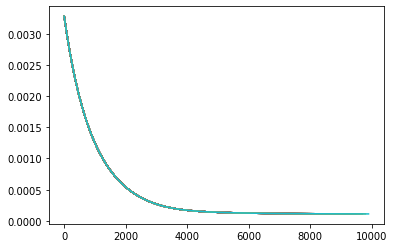

In [387]:
for i in range(10000):
    optimizer.zero_grad()
    prob = do_full_bracket_multi_level(human_ratings_tensor,xp)
    loss = loss_func(prob,target)
    loss.backward()
    losses.append(loss.detach().numpy())
    optimizer.step()
    if i%100==0:
        print(i,loss.detach().numpy())
        plt.plot(losses)
        #print(ratings_tensor)


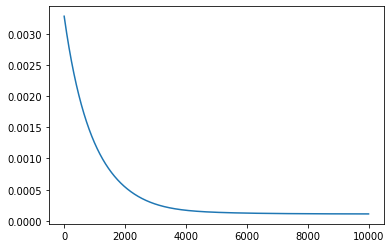

In [388]:
ratings_tensor
plt.plot(losses)

In [389]:

human_ratings_np = human_ratings_tensor.detach().numpy()
prob_np = prob.detach().numpy()
target_np = target.numpy()
names_prob = list(zip(names,human_ratings_np,prob_np,target_np))
sorted(names_prob,key=lambda x: -x[2])

[('Gonzaga', 29.377132, 0.9864856, 0.977184),
 ('Baylor', 24.020514, 0.97605705, 0.961392),
 ('Illinois', 24.692236, 0.97520465, 0.955053),
 ('Michigan', 23.099136, 0.973291, 0.956712),
 ('Ohio St.', 20.054392, 0.9667928, 0.952931),
 ('Iowa', 20.943422, 0.9659358, 0.959706),
 ('Houston', 18.34067, 0.9510989, 0.935286),
 ('Kansas', 19.366982, 0.9469647, 0.939874),
 ('Texas', 18.775782, 0.93951607, 0.926278),
 ('Alabama', 19.63144, 0.93674564, 0.924722),
 ('West Virginia', 18.012302, 0.9270911, 0.907206),
 ('Florida St.', 16.989653, 0.91854566, 0.902665),
 ('Purdue', 14.5259495, 0.90104693, 0.886197),
 ('Arkansas', 15.370634, 0.8650632, 0.851917),
 ('Oklahoma St.', 17.303885, 0.85863674, 0.842984),
 ('Virginia', 17.108685, 0.8506472, 0.845838),
 ('USC', 14.216245, 0.8126195, 0.793014),
 ('Tennessee', 14.955133, 0.7779553, 0.757456),
 ('Creighton', 14.889521, 0.7591516, 0.749402),
 ('Villanova', 16.145567, 0.75700843, 0.737188),
 ('Texas Tech', 14.371586, 0.75041974, 0.729478),
 ('BYU', 1

In [406]:
names_prob = list(zip(names,human_ratings_np,ratings,human_ratings_np-ratings))
print("{},{},{},{}".format("Team", "Infered human rating", "Computer rating", "diff"))
for name, hr, tr, diff in sorted(names_prob,key=lambda x: -x[1]):
    print("{},{:.2f},{},{:.2f}".format(name, hr, tr, diff))

Team,Infered human rating,Computer rating,diff
Gonzaga,29.38,25.9,3.48
Illinois,24.69,21.7,2.99
Baylor,24.02,23.1,0.92
Michigan,23.10,20.4,2.70
Iowa,20.94,20.9,0.04
Ohio St.,20.05,17.5,2.55
Alabama,19.63,18.0,1.63
Kansas,19.37,17.1,2.27
Texas,18.78,16.5,2.28
Houston,18.34,19.9,-1.56
West Virginia,18.01,16.2,1.81
Oklahoma St.,17.30,14.3,3.00
Virginia,17.11,16.2,0.91
Florida St.,16.99,16.7,0.29
Villanova,16.15,17.9,-1.75
Arkansas,15.37,16.2,-0.83
Tennessee,14.96,16.5,-1.54
Creighton,14.89,16.9,-2.01
North Carolina,14.69,14.9,-0.21
Purdue,14.53,15.2,-0.67
SDSU,14.51,14.5,0.01
Texas Tech,14.37,16.9,-2.53
USC,14.22,15.9,-1.68
Oregon,14.18,13.9,0.28
Oklahoma,13.73,14.1,-0.37
BYU,13.58,13.9,-0.32
Wisconsin,13.53,15.9,-2.37
Colorado,13.34,16.0,-2.66
LSU,13.16,14.6,-1.44
Georgetown,13.09,9.7,3.39
Connecticut,12.60,15.2,-2.60
Syracuse,12.55,12.3,0.25
Loyola (IL),12.10,13.9,-1.80
Maryland,12.04,12.6,-0.56
Georgia Tech,11.49,13.1,-1.61
Florida,11.10,13.2,-2.10
Clemson,11.03,12.5,-1.47
Missouri,10.

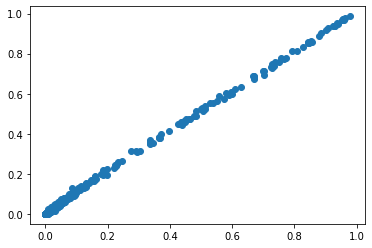

In [391]:
plt.scatter(target_np,prob_np)


In [392]:
from scipy.stats import norm

x = np.linspace(-20,20,100)
norm = norm.cdf(x, loc=0, scale=9.5)
logisitic = (1/(1+(e*2)**(-(x)/9.5) ) )

In [393]:
targets = [[human_picks[name][x]/100. for name in names] for x in range(6)]

In [394]:
def do_full_bracket_print(rankings,prob):
    probs = []
    power = math.log(rankings.shape[0])/math.log(2)
    assert power.is_integer(), "must be multiple of two"
    power = int(power)
    for x in range(power):
        l_power = 2**x
        prob,n_rounds = one_round(rankings,prob,2*l_power,l_power,logisitic)
        probs.append(prob.detach().numpy())
        #print(prob)
    return probs

In [395]:
predicted = do_full_bracket_print(human_ratings_tensor,xp)

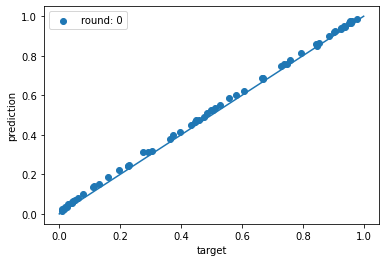

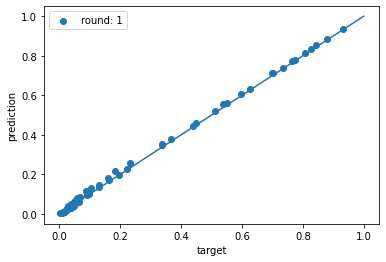

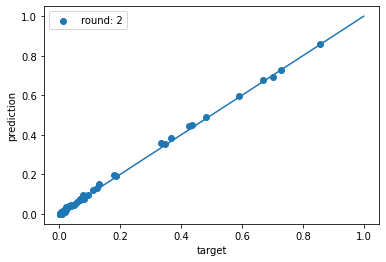

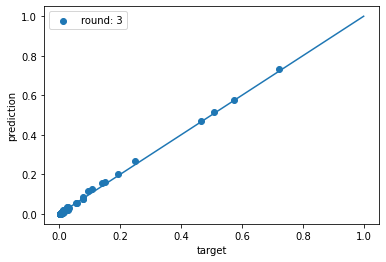

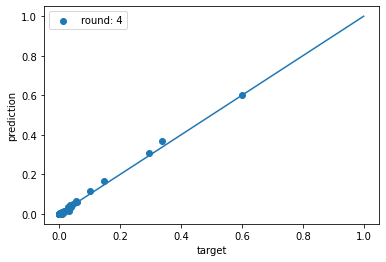

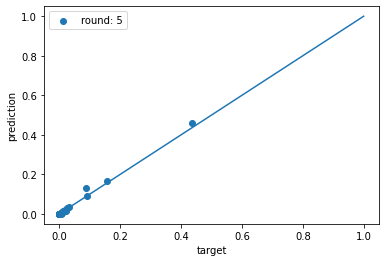

<Figure size 432x288 with 0 Axes>

In [396]:
for i,(pred, tar) in enumerate(zip(predicted,targets)):
    plt.scatter(tar,pred, label="round: {}".format(i))
    plt.ylabel("prediction")
    plt.xlabel("target")
    x = np.linspace(0,1,3)
    plt.plot(x,x)
    plt.legend()
    plt.show()
    plt.clf()

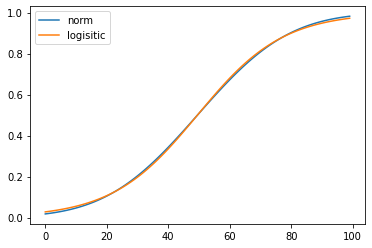

In [706]:
plt.plot(norm, label="norm")
plt.plot(logisitic, label="logisitic")
plt.legend()

In [703]:
2.7*2

5.4

In [229]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)
output.backward()

In [230]:
input

tensor([[-0.6440, -0.6569,  0.7668, -1.3241, -0.2552],
        [ 0.5537,  1.8828, -0.3636,  0.9727,  1.1204],
        [-1.0023,  1.0026, -0.5451, -0.3423,  1.0632]], requires_grad=True)

In [231]:
target

tensor([1, 0, 4])